## Greedy Permutation

Sometimes, you will want to perform persistent homology on a point cloud with many points, but as you may have discovered, ripser.py grinds to a halt even on H1 if the number of points exceeds around 1000.  To mitigate this, we provide a routine that intelligently subsamples the points via "furthest point sampling."  Please see
https://gist.github.com/ctralie/128cc07da67f1d2e10ea470ee2d23fe8
or refer to the paper


[1] Nicholas J Cavanna, Mahmoodreza Jahanseir, Donald R Sheehy, "A geometric perspective on sparse filtrations" 


for more details.



In [1]:
%load_ext autoreload
%autoreload 2
from ripser import ripser, plot_dgms
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import time

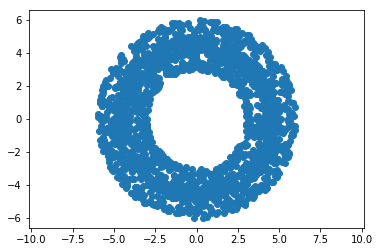

In [2]:
X = datasets.make_circles(n_samples=2000)[0] + 5 * datasets.make_circles(n_samples=2000)[0]
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

First, we will compute H0 and H1 on the full point cloud of 2000 points

In [3]:
tic = time.time()
dgms_full = ripser(X)['dgms']
toc = time.time()
print("Elapsed Time Full Point Cloud: %.3g seconds"%(toc-tic))

Elapsed Time Full Point Cloud: 40.4 seconds


Now, we will subsample 400 points in the point cloud (a factor of 5 reduction) and perform persistent homology

In [4]:
tic = time.time()
res = ripser(X, n_perm=400)
toc = time.time()
print("Elapsed Time Subsampled Point Cloud: %.3g seconds"%(toc-tic))
dgms_sub = res['dgms']
idx_perm = res['idx_perm']
r_cover = res['r_cover']

Elapsed Time Subsampled Point Cloud: 0.347 seconds


Notice how this only took a split second!  But how good is the approximation?  We can plot the points that were used in the subsample to see visually, and we can look at the persistence diagrams.  

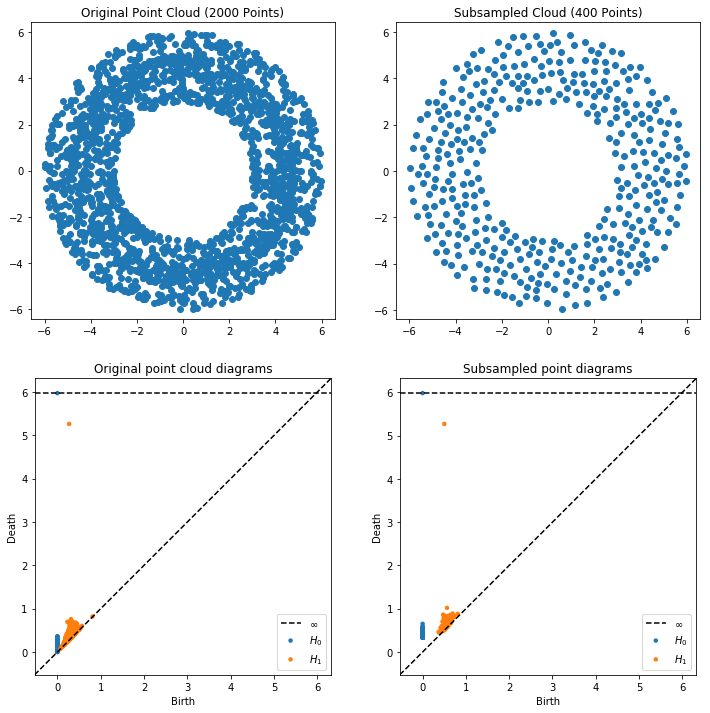

In [5]:
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.scatter(X[:, 0], X[:, 1])
plt.title("Original Point Cloud (%i Points)"%(X.shape[0]))
plt.axis("equal")
plt.subplot(222)
plt.scatter(X[idx_perm, 0], X[idx_perm, 1])
plt.title("Subsampled Cloud (%i Points)"%(idx_perm.size))
plt.axis("equal")
plt.subplot(223)
plot_dgms(dgms_full)
plt.title("Original point cloud diagrams")
plt.subplot(224)
plot_dgms(dgms_sub)
plt.title("Subsampled point diagrams")
plt.show()


But we also have information about the "covering radius," or the radius of balls placed at the subsampled points that cover all of the original points.  In fact, twice the covering radius bounds from above the bottleneck distance between all approximate persistence diagrams and their corresponding original persistence diagram

In [6]:
def getBottleneckDist(S, T):
    """
    Perform the Bottleneck distance matching between persistence diagrams.
    Assumes first two columns of S and T are the coordinates of the persistence
    points, but allows for other coordinate columns (which are ignored in
    diagonal matching)
    :param S: Mx(>=2) array of birth/death pairs for PD 1
    :param T: Nx(>=2) array of birth/death paris for PD 2
    :returns total cost
    """
    from bisect import bisect_left
    from hopcroftkarp import HopcroftKarp
    
    S = S[np.isfinite(S[:, 1]), :]
    T = T[np.isfinite(T[:, 1]), :]
    
    N = S.shape[0]
    M = T.shape[0]
    # Step 1: Compute CSM between S and T, including points on diagonal
    # L Infinity distance
    Sb, Sd = S[:, 0], S[:, 1]
    Tb, Td = T[:, 0], T[:, 1]
    D1 = np.abs(Sb[:, None] - Tb[None, :])
    D2 = np.abs(Sd[:, None] - Td[None, :])
    DUL = np.maximum(D1, D2)
    # Put diagonal elements into the matrix, being mindful that Linfinity
    # balls meet the diagonal line at a diamond vertex
    D = np.zeros((N+M, N+M))
    D[0:N, 0:M] = DUL
    UR = np.max(D)*np.ones((N, N))
    np.fill_diagonal(UR, 0.5*(S[:, 1]-S[:, 0]))
    D[0:N, M::] = UR
    UL = np.max(D)*np.ones((M, M))
    np.fill_diagonal(UL, 0.5*(T[:, 1]-T[:, 0]))
    D[N::, 0:M] = UL

    # Step 2: Perform a binary search + Hopcroft Karp to find the
    # bottleneck distance
    N = D.shape[0]
    ds = np.unique(D.flatten())
    ds = ds[ds > 0]
    ds = np.sort(ds)
    bdist = ds[-1]
    matching = {}
    while len(ds) >= 1:
        idx = 0
        if len(ds) > 1:
            idx = bisect_left(range(ds.size), int(ds.size/2))
        d = ds[idx]
        graph = {}
        for i in range(N):
            graph['%s'%i] = {j for j in range(N) if D[i, j] <= d}
        res = HopcroftKarp(graph).maximum_matching()
        if len(res) == 2*N and d < bdist:
            bdist = d
            matching = res
            ds = ds[0:idx]
        else:
            ds = ds[idx+1::]
    return bdist


print("Twice Covering radius: %.3g"%(2*r_cover))
for dim, (I1, I2) in enumerate(zip(dgms_full, dgms_sub)):
    bdist = getBottleneckDist(I1, I2)
    print("H%i bottleneck distance: %.3g"%(dim, bdist))

Twice Covering radius: 0.655
H0 bottleneck distance: 0.292
H1 bottleneck distance: 0.231
